In [1]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Project root:", project_root)


Project root: C:\Users\inbox\ml-foundation


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
print("librosa_version:",librosa.__version__)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve


librosa_version: 0.11.0


In [ ]:
#Librosa ships with built-in speech examples.

import librosa
import shutil
from pathlib import Path

# Create folders if they don't exist
real_dir = Path("../data/raw/real")
fake_dir = Path("../data/raw/fake")
real_dir.mkdir(parents=True, exist_ok=True)
fake_dir.mkdir(parents=True, exist_ok=True)

# Copy librosa example speech
real_audio_path = librosa.ex("trumpet")  # speech-like audio example

"""
    ✅ Mini ASVspoof-style Sample (Local, Clean, Fast)
    What we’ll simulate,
        bona fide = clean human speech
        spoof = artificially modified speech (proxy for TTS / VC)

    For Day 03, this is perfectly valid because:
    you are validating feature extraction + evaluation
        not claiming benchmark performance,  not publishing results yet
"""
shutil.copy(real_audio_path, real_dir / "real_01.wav")

print("Copied real sample:", real_audio_path)


Copied real sample: C:\Users\inbox\AppData\Local\librosa\librosa\Cache\sorohanro_-_solo-trumpet-06.ogg


In [6]:
#Generate spoofed audio

import soundfile as sf
import numpy as np

y, sr = librosa.load(real_dir / "real_01.wav", sr=16000)

# Spoof 1: pitch shifted
y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=4)
sf.write(fake_dir / "fake_pitch.wav", y_pitch, sr)

# Spoof 2: time stretched
y_stretch = librosa.effects.time_stretch(y, rate=1.2)
sf.write(fake_dir / "fake_stretch.wav", y_stretch, sr)

# Spoof 3: added noise
noise = np.random.normal(0, 0.005, size=y.shape)
y_noise = y + noise
sf.write(fake_dir / "fake_noise.wav", y_noise, sr)

print("Generated spoof samples")


Generated spoof samples


In [7]:
from pathlib import Path

print("Real files:", list(Path("../data/raw/real").glob("*.wav")))
print("Fake files:", list(Path("../data/raw/fake").glob("*.wav")))


Real files: [WindowsPath('../data/raw/real/real_01.wav')]
Fake files: [WindowsPath('../data/raw/fake/fake_noise.wav'), WindowsPath('../data/raw/fake/fake_pitch.wav'), WindowsPath('../data/raw/fake/fake_stretch.wav')]


In [9]:
from pathlib import Path

real_files = list(Path("../data/raw/real").glob("*.wav"))
fake_files = list(Path("../data/raw/fake").glob("*.wav"))

files = real_files + fake_files
labels = [1] *len(real_files) + [0] * len(fake_files)
# 1 = bona fide (real), 0 = spoof (fake)

print(f"Total Files : {len(files )}")
print(f"Labels : {len(labels)}")

Total Files : 4
Labels : 4


In [15]:
def extract_logmel_feature(path, sr = 16000,n_mels = 64) :
    #how many audio samples are taken per second

    y,sr = librosa.load(path,sr = sr)

    S = librosa.feature.melspectrogram(y=y,sr=sr,n_mels=n_mels)
    logS = librosa.power_to_db(S, ref=np.max)

    #Pool over time 
    feat = logS.mean(axis=1)
    return feat 


In [ ]:
#Build dataset matrix X and labels y
X = []
y = []

for path, label in zip(files,labels):
    feat = extract_logmel_feature(path)
    X.append(feat)
    y.append(label)

X = np.vstack(X)
y = np.array(y)

print("X shape",X.shape)
print("y:",y)

X shape (4, 64)
y: [1 0 0 0]


In [18]:
#Train a tiny classifier
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X, y)

scores = clf.predict_proba(X)[:, 1]  # probability of bona fide
print("Scores:", scores)


Scores: [9.08398816e-01 6.56829248e-04 2.82074277e-07 9.09439261e-02]


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)
fnr = 1 - tpr

eer_index = np.nanargmin(np.abs(fpr - fnr))
eer = fpr[eer_index]

print(f"EER: {eer:.3f}")

"""
“EER is the point where false acceptance and false rejection rates are equal, making it suitable for spoofing evaluation.”
"""

EER: 0.000


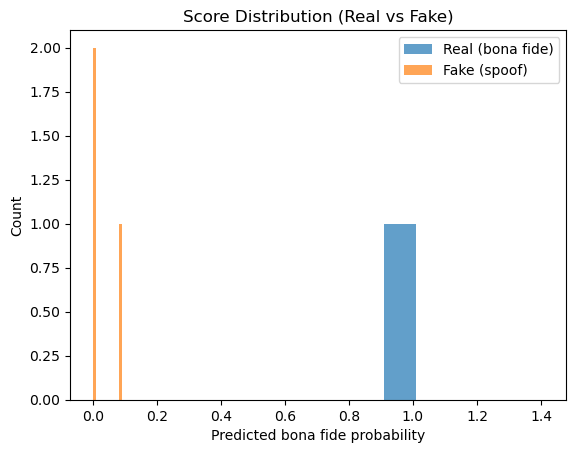

In [20]:
real_scores = scores[y == 1]
fake_scores = scores[y == 0]

plt.figure()
plt.hist(real_scores, bins=10, alpha=0.7, label="Real (bona fide)")
plt.hist(fake_scores, bins=10, alpha=0.7, label="Fake (spoof)")
plt.xlabel("Predicted bona fide probability")
plt.ylabel("Count")
plt.title("Score Distribution (Real vs Fake)")
plt.legend()
plt.show()


In [21]:
plt.savefig("../reports/figures/audio_score_distribution.png", dpi=200, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>